# Individual Category Time Series Modelling
Use the most up-to-date CPI data from the Stats SA website. Investigate each category individualy and compare the forcasts from the Holt-Winters with an ARIMA model.

Determine which additional data can be used to improve the forecasting for each category and where necessary fit a VAR or VARMA model after making the time series stationary.

## Import Libraries

In [811]:
# Import libraries
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import pathlib


# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from pmdarima.arima.utils import nsdiffs

from sklearn.metrics import mean_squared_error
from math import sqrt

# Import packages
import plotly.graph_objects as go

# import nbformat
import plotly.io as pio
pio.renderers.default='notebook_connected'


In [812]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Define Date for Prediction
This will be updated every month to include the new date

## Import the Different Data Sets
Import the following data sets:

- `EXCEL - CPI(5 and 8 digit) from Jan 2017 (202306).xlsx`: this will be used to do the EDA and predictions of the CPI values.
- currency as supplied by zindi
- jse data as supplied by zindi
-  Monthly credit detail excel released by the reserve bank (https://www.resbank.co.za/en/home/what-we-do/statistics/releases/selected-statistics)
- fuel prices pulled from open price engin

In [813]:
# get directory path
path = str(pathlib.Path().cwd().parent.parent.resolve())

In [814]:
raw_df = pd.read_excel(path + "/data/EXCEL - CPI(5 and 8 digit) from Jan 2017 (202305).xlsx", dtype="object")

## Review the Historical CPI data and Create a Summary DataFrame
There are 12 main categories that are used to calculate the Headline CPI. Each category has a number of sub categories. This data set contains the CPI on sub-category level.

Create a dataset where the CPI is calculated on the category level. These values will then be used in the models to predict the CPI for the different categories as well as the Headline CPI.

In terms of cleaning the data, I will do the following:
- Remove unnecessary columns.
- Change column headers to make them more explanatory.
- Replace all `..` entries with a `0`. 
- Combine the `Super maize` and `Special maize` categories into a single `Maize meal` category, to correspond with the current use of maize meal.
- Create a function to calculate the CPI values for each month using the weights provided in the file.


In [815]:
# Create a category dictionary with the category code and description
category_dict = {"01":"Food and non-alcoholic beverages",
                 "02":"Alcoholic beverages and tobacco",
                 "03":"Clothing and footwear",
                 "04":"Housing and utilities",
                 "05":"Household contents and services",
                 "06":"Health",
                 "07":"Transport",
                 "08":"Communication",
                 "09":"Recreation and culture",
                 "10":"Education",
                 "11":"Restaurants and hotels",
                 "12":"Miscellaneous goods and services",
                 "headline": "headline CPI"
}

In [816]:
def get_montly_cpi(raw_df):
    """Function that takes the raw cpi data for each product from statssa and calculates the cpi value per category
    
    Arguments:
    ----------
    raw_df: pandas dataframe
            dataframe containing raw data from statsa

    Return:
    -------
    df_cpi: pandas dataframe
            dataframe containing the monthly cpi per category
    """

    # 1. remove unecessary columns and rename
    list_cols_to_drop = ['H01','H02','H05','H06','H07']
    cat_cpi_df = raw_df.copy().drop(list_cols_to_drop, axis=1).copy()

    cat_cpi_df.rename(columns = {'H03':'category_codes', 'H04':'category_descr', 
                             'Weight (All urban)':'weights_urban'}, inplace = True)

    # 2. replace .. with zeros
    cat_cpi_df.replace("..", 0, inplace=True)

    # 3. combine maize meal categories
    cat_cpi_df.iloc[17:19] = cat_cpi_df.iloc[17:19].copy().apply(pd.to_numeric, errors='coerce')
    divided_row = (cat_cpi_df.iloc[17].copy()+cat_cpi_df.iloc[18].copy())/2
    cat_cpi_df.iloc[15] = [divided_row[i] if value == 0 else value for i, value in enumerate(cat_cpi_df.iloc[15].copy())]  
    cat_cpi_df.drop([cat_cpi_df.index[17], cat_cpi_df.index[18]], inplace=True)

    # Convert the 'weights_urban' column to float
    cat_cpi_df['weights_urban'] = cat_cpi_df['weights_urban'].astype('float')

    # 4. calculate cpi
    # Assign a main category code to each raw data row.
    main_category = []
    for index, row in cat_cpi_df.iterrows():
        if (len(row['category_codes']) == 8) & (row['category_codes'][:2] in ["01","02"]):
            main_category.append(row['category_codes'][:2])
        elif (len(row['category_codes']) == 5):  # & (row['category_codes'][:2] not in ["04","07"]):
            main_category.append(row['category_codes'][:2])
        else:
            main_category.append("no")
    
    cat_cpi_df['main_category_code'] = main_category
    
    # Drop the rows where the main_category_code is "no". That is to prevent double counting.
    # Some categories have a sub category included in the data.
    cat_cpi_df.drop(cat_cpi_df[cat_cpi_df['main_category_code'] == "no"].index, inplace = True)
    
    # Sum the weights for each category
    sum_weights = cat_cpi_df.groupby('main_category_code')['weights_urban'].sum()
    
    # create new cpi dataframe
    cpi_df = pd.DataFrame()
    
    # For each month create the headline CPI value and the CPI value per category. 
    for col in range(3, cat_cpi_df.shape[1]-1):
        cat_cpi_df = cat_cpi_df.copy()
        column_name = cat_cpi_df.columns[col]
        cat_cpi_df['weighted_index_' + column_name] = cat_cpi_df['weights_urban']*cat_cpi_df[column_name]
    
        sum_weighted_index = cat_cpi_df.groupby('main_category_code')['weighted_index_' + column_name].sum()
        
        # Concatenate the DataFrames horizontally
        concat_df = pd.concat([sum_weights, sum_weighted_index], axis=1)
        
        # Add a row that sums the values in the columns
        sums_df = pd.DataFrame(concat_df.sum().values.reshape(1, -1), columns=concat_df.columns)
        sums_df = sums_df.set_index(pd.Index(["headline"]))
        
        # Concatenate the headline dataframe to the categories
        month_cpi_df = pd.concat([concat_df, sums_df], axis=0) 
        
        # Calculate the CPI value
        month_cpi_df['cpi_' + column_name] = (month_cpi_df['weighted_index_' + column_name] / 
                                            month_cpi_df['weights_urban']).round(1)
        
        cpi_df = pd.concat([cpi_df, month_cpi_df[['weights_urban', 'cpi_'+column_name]]], axis=1)
    
    # Remove duplicate weights columns and reset the index
    cpi_df = cpi_df.loc[:, ~cpi_df.columns.duplicated()]
    cpi_df = cpi_df.reset_index().rename(columns={'index':'category'})
    
    # Dataframe with just the CPI values:
    cpi_df = cpi_df.drop('weights_urban', axis=1).copy()
    transposed_cpi_df = cpi_df.set_index('category').transpose().reset_index()
    transposed_cpi_df['date'] = transposed_cpi_df['index'].apply(lambda x: x.split('M')[-1])
    transposed_cpi_df['date'] = transposed_cpi_df['date'].apply(lambda x: x[:4] + '-' + x[-2:])
    # change month to datetime format
    transposed_cpi_df['date'] = pd.to_datetime(transposed_cpi_df['date']).dt.strftime('%Y-%m')
    transposed_cpi_df = transposed_cpi_df.set_index('date')
    transposed_cpi_df.index = pd.DatetimeIndex(transposed_cpi_df.index.values)
    
    return(transposed_cpi_df.drop(['index'], axis=1))

In [817]:
cpi = get_montly_cpi(raw_df=raw_df)

In [818]:
def plot_montly_cpi(cpi_df, cat_dict):
        """Plots monthly cpi
    
        Arguments:
        ----------
        cpi_df: pandas dataframe
                monthly cpi of each category
                
        cat_dict: dict
                dictionary mapping category numbers to category names            
        """

        ax = cpi_df.plot.line(linewidth=1, figsize=(20,10))  # Set the default linewidth
        ax.lines[12].set_linewidth(3)

        # Modify the legend labels
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [category_dict.get(label, label) for label in labels]
        plt.legend(handles, new_labels)

        # Adding labels and title
        plt.xlabel('Month')
        plt.ylabel('CPI')
        plt.title('Headline and Category CPI Values from 2017 to 2023')

        # Displaying the graph
        plt.show()

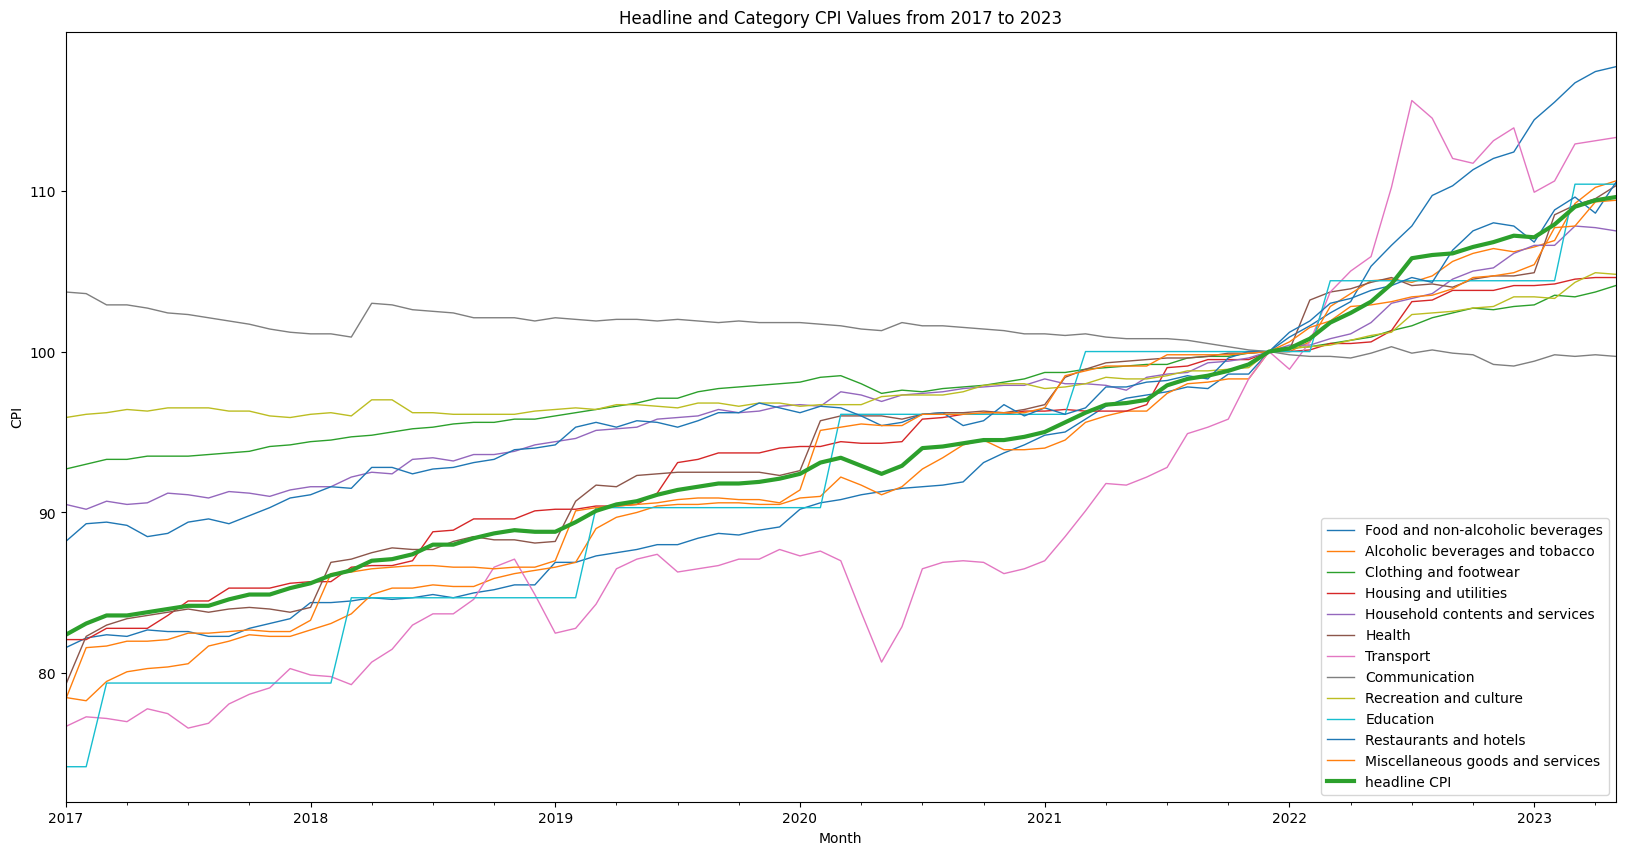

In [819]:
plot_montly_cpi(cpi_df=cpi, cat_dict=category_dict)

# Add additional Features

In [820]:
currency = pd.read_csv(path + '/data/currency_data.csv')
credit = pd.read_excel(path + '/data/credit.xlsx', header=1)
jse = pd.read_csv(path + '/data/jse_indices.csv')
fuel = pd.read_csv(path + '/data/fuel_df.csv').drop(['Unnamed: 0'], axis=1)
sabor = pd.read_csv(path + '/data/sabor.csv')

In [821]:
currency['Date'] = pd.to_datetime(currency['Date']).dt.strftime('%Y-%m')
jse['Date'] = pd.to_datetime(jse['date']).dt.strftime('%Y-%m')
credit['date'] = pd.to_datetime(credit['Date'], format='%b, %Y')
credit['Date'] = pd.to_datetime(credit['date']).dt.strftime('%Y-%m')
fuel['Date'] = pd.to_datetime(fuel['date']).dt.strftime('%Y-%m')
sabor['Date'] = pd.to_datetime(sabor['date']).dt.strftime('%Y-%m')

In [822]:
currency_new = currency[currency['Date'] > '2018']
jse_new = jse[jse['Date'] > '2018']
credit_new= credit[credit['Date'] > '2018']
fuel_new= fuel[fuel['Date'] > '2018']
sabor_new= sabor[sabor['Date'] > '2018']

We need to correct some datafields that are seen as strings in the credit data

In [823]:
def remove_commas_and_convert_to_float(value):
    return float(value.replace(',', ''))

In [824]:
credit_new = credit_new.drop(['Share of corporations as a % of total credit',
       'Share of corporations as a % of total loans & advances',
       'Share of households as a % of total credit',
       'Share of households as % of total loans & advances', 'Investments'], axis=1)

In [825]:
credit_columns = ['Instalment sale credit', 'Leasing finance',
       'Mortgage advances', 'Overdrafts', 'General loans and advances',
       'Credit card advances', 'Of which: Total to households',
       'Total loans and advances : Households',
       'Claims on the domestic private sector',
       'Total loans and advances (excl. investments & bills)',
       'Bills discounted', 'Instalment sale credit.1', 'Leasing finance.1',
       'Mortgage advances.1', 'Overdrafts.1', 'General loans and advances.1',
       'Credit card advances.1', 'Of which: Total to corporations',
       'Claims on the domestic private sector.1',
       'Total loans and advances : Corporations',]

In [826]:
credit_new[credit_columns] = credit_new[credit_columns].applymap(remove_commas_and_convert_to_float)


# Create Features

In some of the excel sheets we do not have up to date. We will there use the feature from 2 months ao as the feature for now (ie march is the predictor for July)

In [827]:
print(jse_new['Date'].max())
print(credit_new['Date'].max())
print(currency_new['Date'].max())
print(fuel_new['Date'].max())
print(sabor_new['Date'].max())

2023-06
2023-06
2023-06
2023-07
2023-06


In [828]:
jse_new['newDate'] = (pd.to_datetime(jse_new['Date']) + pd.DateOffset(months=2)).dt.strftime('%Y-%m')
credit_new['newDate'] = (pd.to_datetime(credit_new['Date']) + pd.DateOffset(months=2)).dt.strftime('%Y-%m')
currency_new['newDate'] = (pd.to_datetime(currency_new['Date']) + pd.DateOffset(months=2)).dt.strftime('%Y-%m')
fuel_new['newDate'] = (pd.to_datetime(fuel_new['Date']) + pd.DateOffset(months=2)).dt.strftime('%Y-%m')
sabor_new['newDate'] = (pd.to_datetime(sabor_new['Date']) + pd.DateOffset(months=2)).dt.strftime('%Y-%m')

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_46045/1032560082.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_46045/1032560082.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [829]:
jse_new = jse_new.drop(['Date', 'date'], axis=1)
credit_new = credit_new.drop(['Date', 'date'], axis=1)
currency_new = currency_new.drop(['Date'], axis=1)
fuel_new = fuel_new.drop(['Date', 'date'], axis=1)
sabor_new = sabor_new.drop(['Date', 'date'], axis=1)

## Get mean per Month for jse and currency

In [830]:
credit_mean = credit_new.groupby(['newDate']).mean().reset_index().add_suffix("mean")
jse_mean = jse_new.groupby(['newDate']).mean().reset_index().add_suffix("mean")
currency_mean = currency_new.groupby(['newDate']).mean().reset_index().add_suffix("mean")
fuel_new = fuel_new.groupby(['newDate']).mean().reset_index()
sabor_new = sabor_new.groupby(['newDate']).mean().reset_index()


jse_std = jse_new.groupby(['newDate']).std().reset_index().add_suffix("std")
currency_std = currency_new.groupby(['newDate']).std().reset_index().add_suffix("std")

credit_min = credit_new.groupby(['newDate']).min().reset_index().add_suffix("min")
jse_min = jse_new.groupby(['newDate']).min().reset_index().add_suffix("min")
currency_min = currency_new.groupby(['newDate']).min().reset_index().add_suffix("min")

credit_max = credit_new.groupby(['newDate']).max().reset_index().add_suffix("max")
jse_max = jse_new.groupby(['newDate']).max().reset_index().add_suffix("max")
currency_max = currency_new.groupby(['newDate']).max().reset_index().add_suffix("max")

In [831]:
credit_new = credit_mean.merge(credit_max, left_on='newDatemean', right_on='newDatemax', how='left').drop(['newDatemax'], axis=1)
credit_new = credit_new.merge(credit_min, left_on='newDatemean', right_on='newDatemin', how='left').drop(['newDatemin'], axis=1)
credit_new = credit_new.rename(columns={"newDatemean": "newDate"})

In [832]:
jse_new = jse_mean.merge(jse_std, left_on='newDatemean', right_on='newDatestd', how='left').drop(['newDatestd'], axis=1)
jse_new = jse_new.merge(jse_max, left_on='newDatemean', right_on='newDatemax', how='left').drop(['newDatemax'], axis=1)
jse_new = jse_new.merge(jse_min, left_on='newDatemean', right_on='newDatemin', how='left').drop(['newDatemin'], axis=1)
jse_new = jse_new.rename(columns={"newDatemean": "newDate"})

In [833]:
currency_new = currency_mean.merge(currency_std, left_on='newDatemean', right_on='newDatestd', how='left').drop(['newDatestd'], axis=1)
currency_new = currency_new.merge(currency_max, left_on='newDatemean', right_on='newDatemax', how='left').drop(['newDatemax'], axis=1)
currency_new = currency_new.merge(currency_min, left_on='newDatemean', right_on='newDatemin', how='left').drop(['newDatemin'], axis=1)
currency_new = currency_new.rename(columns={"newDatemean": "newDate"})

In [834]:
cpi_features = sabor_new.merge(jse_new, right_on='newDate', left_on='newDate', how='left')
cpi_features = cpi_features.merge(credit_new, right_on='newDate', left_on='newDate', how='left')
cpi_features = cpi_features.merge(currency_new, right_on='newDate', left_on='newDate', how='left')
cpi_features = cpi_features.merge(fuel_new, right_on='newDate', left_on='newDate', how='left')

In [835]:
cpi_features = cpi_features[['newDate',  'sabor', 'fuel_price', 'USD/ZARmin', 'Credit card advancesmean', 'Total loans and advances : Householdsmean',
                             ]]
cpi_features['newDate'] = pd.to_datetime(cpi_features['newDate'])


## Review Categories Individualy

Determine if the forecasted values can be improved by importing additional data and fitting a  VARIMA model.

In [836]:
from statsmodels.tsa.vector_ar.var_model import VAR


In [837]:
def find_best_model(cpi, cpi_features, colname):
        """Function that finds the best model based on performance.

        Arguments:
        ----------
        train_series: pandas dataframe
                      dataframe with monthly cpi values to train model
        colname: str
                 name of category
        
        Returns:
        --------
        model: fitted model

        """
 
        cpi = cpi.reset_index()[['index', colname]]
        data = cpi.merge(cpi_features, right_on='newDate', left_on='index', how='left')

        prediction_date = pd.to_datetime(data['newDate'].max()) + pd.DateOffset(months=1)
        
        data = data.drop(['index'], axis=1).set_index('newDate')
        data.rename(columns = {colname:'y'}, inplace = True)

        model = VAR(endog=data)
        model_fit = model.fit()

        prediction = model_fit.forecast(model_fit.endog, steps=1)
        results = pd.DataFrame({'Date': [prediction_date], 'prediction': [prediction[0][0]], 'cat': [colname]})
        
        cpi_dict[colname] = results
    
        return results

### Get predictions

In [838]:
# Create a dictionary where the predicted CPI for each category will be stored.
cpi_dict={}

In [839]:
# monthly_cpi_df
# Only use the last 24 months for training
reduced_monthly_cpi = cpi.drop(index=cpi.index[:24]).copy()

### Category 1: Food and non-alcoholic beverages

In [840]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='01')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  118.703173  01


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 2: Alcoholic beverages and tobacco

In [841]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='02')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  111.063306  02


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 3: Clothing and footwear

In [842]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='03')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  104.288163  03


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 4: Housing and utilities

In [843]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='04')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  104.887194  04


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 5: Household contents and services

In [844]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='05')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  108.000799  05


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 6: Health

In [845]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='06')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  110.239469  06


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 7: Transport

In [846]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='07')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  113.625073  07


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 8: Communication

In [847]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='08')
print(cat_pred)

        Date  prediction cat
0 2023-06-01   99.703769  08


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 9: Recreation and culture

In [848]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='09')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  105.042274  09


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 10: Education

In [849]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='10')
print(cat_pred)

        Date  prediction cat
0 2023-06-01   110.43292  10


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 11: Restaurants and hotels

In [850]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='11')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  110.528464  11


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Category 12: Miscellaneous goods and services

In [851]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='12')
print(cat_pred)

        Date  prediction cat
0 2023-06-01  109.553204  12


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Headline CPI

##### ARIMA
Use auto_arima to find the best model.

In [852]:
cat_pred = find_best_model(reduced_monthly_cpi, cpi_features=cpi_features, colname='headline')
print(cat_pred)

        Date  prediction       cat
0 2023-06-01  110.054338  headline


/opt/miniconda3/envs/zindi_rmb/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Create Dataframe for Submission

In [853]:
prediction_df = pd.concat(cpi_dict).rename(columns={'cat': 'ID', 'prediction':'Value' })

In [854]:
pred_month = pd.to_datetime(prediction_df['Date'].unique()[0]).strftime('%B')
pred_month

'June'

In [855]:
# drop the month from the dataframe
prediction_df.drop(['Date'], axis=1, inplace=True)

In [856]:
# Create a dictionary to update the category names to allow a submission to Zindi.
# month="May"
pred_category_dict = {"01":pred_month+"_food and non-alcoholic beverages",
                      "02":pred_month+"_alcoholic beverages and tobacco",
                      "03":pred_month+"_clothing and footwear",
                      "04":pred_month+"_housing and utilities",
                      "05":pred_month+"_household contents and services",
                      "06":pred_month+"_health",
                      "07":pred_month+"_transport",
                      "08":pred_month+"_communication",
                      "09":pred_month+"_recreation and culture",
                      "10":pred_month+"_education",
                      "11":pred_month+"_restaurants and hotels",
                      "12":pred_month+"_miscellaneous goods and services",
                      "headline":pred_month+"_headline CPI"
}

In [857]:
prediction_df = prediction_df.replace(pred_category_dict)
prediction_df

,,Value,ID
01,0,118.703173,June_food and non-alcoholic beverages
02,0,111.063306,June_alcoholic beverages and tobacco
03,0,104.288163,June_clothing and footwear
04,0,104.887194,June_housing and utilities
05,0,108.000799,June_household contents and services
06,0,110.239469,June_health
07,0,113.625073,June_transport
08,0,99.703769,June_communication
09,0,105.042274,June_recreation and culture
10,0,110.432920,June_education


In [858]:
# output to csv file
prediction_df[['ID', 'Value']].to_csv(path + f'/submissions/varima_{pred_month}.csv', index = 0)